### Importing all the required Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
# confusion metric and accuracy score evaluation
from sklearn.metrics import confusion_matrix,accuracy_score
# Precision and recall
from sklearn.metrics import classification_report
# ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Importing the training and the test set

In [2]:
df_mush = pd.read_csv("/Users/bhavneetsingh/Desktop/ML Assignment/ML_assignment-1_mushrooms.csv")
df_mush.drop(["Unnamed: 0"], inplace = True, axis = 1)
df_mush.shape

(1885, 13)

In [3]:
df_mush.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impuslive,ss,mushrooms
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,non-user
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,non-user
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,non-user
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,non-user
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,user


### Splitting the dataset into test set and training set

In [4]:
X_mush = df_mush.iloc[:,:-1].values
y_mush = df_mush.iloc[:,-1:].values
X_train,X_test,y_train,y_test = train_test_split(X_mush,y_mush,test_size=0.33,
                                                                    stratify=y_mush, random_state=42)

### Training the Gradient Boosting algorithm with hyper-parameter tuning using Grid Search

In [5]:
gradient_boost = []
self_training = []
co_training = []
semi_boost_accuracy = []
pca_semi_supervised = []

In [6]:
def supervised_baseline_gradientBoosting(X_train, y_train, X_test, y_test, percentages=[10, 20, 30, 40, 50]):
    """
    Train Gradient Boosting supervised baseline on varying labeled percentages and evaluate.
    
    Parameters:
    - X: Feature matrix.
    - y: Target labels.
    - test_size: Fraction of the data to use as the test set.
    - percentages: List of labeled data percentages to evaluate.

    Returns:
    - None (Plots the ROC curves for the baseline).
    """
    
    plt.figure(figsize=(10, 6))
    
    y_train[y_train == "user"] = 1
    y_train[y_train == "non-user"] = 0
    y_test[y_test == "user"] = 1
    y_test[y_test == "non-user"] = 0

    for pct in percentages:
        # Determine the number of labeled samples
        n_labeled = int(len(X_train) * pct / 100)
        X_labeled, y_labeled = X_train[:n_labeled].astype('int'), y_train[:n_labeled].astype('int')
        y_labeled = y_labeled.ravel()
        param_dist = {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
        gb = GradientBoostingClassifier(random_state=42)
        random_search = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=10, scoring='accuracy', cv=5)
        random_search.fit(X_labeled, y_labeled)

        # Train the best model
        best_gb = random_search.best_estimator_
        best_gb.fit(X_labeled, y_labeled)

        y_test = y_test.astype('int')
        y_test = y_test.ravel()
        # Predict probabilities on the test set
        probas = best_gb.predict_proba(X_test)[:, 1]
        y_pred = best_gb.predict(X_test)
        
        print(f"Classification report with {pct}% of labelled data");
        accuracy = accuracy_score(y_test, y_pred)
        gradient_boost.append(accuracy)
        print(classification_report(y_test, y_pred))
    
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, probas)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{pct}% labeled (AUC = {roc_auc:.2f})')
    
    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    
    # Customize plot
    plt.title('ROC Curve for Gradient Boosting Baseline')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classification report with 10% of labelled data
              precision    recall  f1-score   support

           0       0.68      0.83      0.75       394
           1       0.53      0.33      0.40       229

    accuracy                           0.65       623
   macro avg       0.60      0.58      0.58       623
weighted avg       0.62      0.65      0.62       623



/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classification report with 20% of labelled data
              precision    recall  f1-score   support

           0       0.69      0.85      0.76       394
           1       0.56      0.33      0.42       229

    accuracy                           0.66       623
   macro avg       0.62      0.59      0.59       623
weighted avg       0.64      0.66      0.63       623



/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classification report with 30% of labelled data
              precision    recall  f1-score   support

           0       0.73      0.82      0.77       394
           1       0.61      0.48      0.53       229

    accuracy                           0.69       623
   macro avg       0.67      0.65      0.65       623
weighted avg       0.68      0.69      0.68       623



/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classification report with 40% of labelled data
              precision    recall  f1-score   support

           0       0.76      0.74      0.75       394
           1       0.57      0.59      0.58       229

    accuracy                           0.69       623
   macro avg       0.66      0.67      0.66       623
weighted avg       0.69      0.69      0.69       623



/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Classification report with 50% of labelled data
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       394
           1       0.57      0.52      0.54       229

    accuracy                           0.68       623
   macro avg       0.65      0.65      0.65       623
weighted avg       0.68      0.68      0.68       623



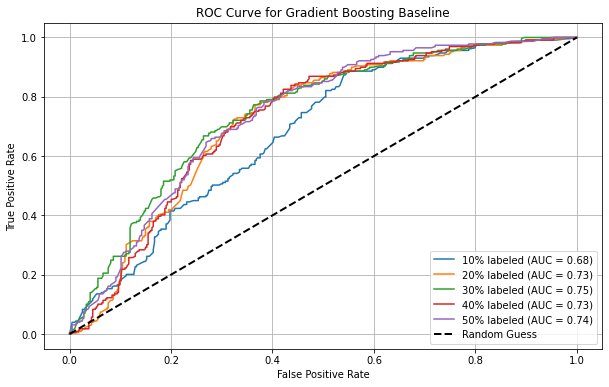

In [7]:
supervised_baseline_gradientBoosting(X_train, y_train, X_test, y_test)

### Semi-supervised learning 

In [8]:
labeled_percentages = [10, 20, 30, 40, 50]

#### A self-training algorithm using labelled data to iteratively label unlabeled instances.

In [9]:
def plot_roc_self_training(X_train, y_train, X_test, y_test, labeled_percentages):
    """
    Generate and plot ROC curves for Self-Training with different percentages of labeled data.
    
    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training labels.
    - X_test: Test feature matrix.
    - y_test: Test labels.
    - labeled_percentages: List of labeled data percentages to test.
    """
    plt.figure(figsize=(10, 6))
    
    y_train[y_train == "user"] = 1
    y_train[y_train == "non-user"] = 0
    y_test[y_test == "user"] = 1
    y_test[y_test == "non-user"] = 0
    
    
    for pct in labeled_percentages:
        # Determine the number of labeled samples
        n_labeled = int(len(X_train) * pct / 100)
        
        # Create labeled and unlabeled datasets
        X_labeled, y_labeled = X_train[:n_labeled], y_train[:n_labeled]
        X_unlabeled = X_train[n_labeled:]
        
        # Combine labeled and unlabeled data
        X_combined = np.vstack((X_labeled, X_unlabeled))
        y_labeled = y_labeled.ravel()
        y_test = y_test.ravel().astype('int')
        y_combined = np.concatenate((y_labeled, [-1] * len(X_unlabeled))).astype('int')
        
        # Train Self-Training model
        base_clf = RandomForestClassifier(random_state=42)
        self_training_model = SelfTrainingClassifier(base_clf, criterion='k_best', k_best=50)
        self_training_model.fit(X_combined, y_combined)
        
        # Predict probabilities for the test set
        y_prob = self_training_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
        y_pred = self_training_model.predict(X_test)
        print(f"Classification report with {pct}% of labelled data");
        print(classification_report(y_test, y_pred))
        accuracy = accuracy_score(y_test, y_pred)
        self_training.append(accuracy)
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{pct}% labeled (AUC = {roc_auc:.2f})')
        
    
    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
    
    # Customize plot
    plt.title("ROC Curve for Self-Training with Varying Labeled Percentages")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

#### A co-training algorithm where two classifiers iteratively label each other's unlabeled instances.

In [10]:
def plot_roc_co_training(X_train, y_train, X_test, y_test, labeled_percentages, max_iter=1):
    """
    Generate and plot ROC curves for Co-Training with different percentages of labeled data.
    
    Parameters:
    - X_train: Training feature matrix.
    - y_train: Training labels.
    - X_test: Test feature matrix.
    - y_test: Test labels.
    - labeled_percentages: List of labeled data percentages to test.
    - max_iter: Maximum number of Co-Training iterations.
    """
    plt.figure(figsize=(10, 6))
    
    y_train[y_train == "user"] = 1
    y_train[y_train == "non-user"] = 0
    y_test[y_test == "user"] = 1
    y_test[y_test == "non-user"] = 0
    
    # Split features for Co-Training (assumes features can be split evenly)
    X_train_1, X_train_2 = np.split(X_train, 2, axis=1)
    X_test_1, X_test_2 = np.split(X_test, 2, axis=1)
    
    for pct in labeled_percentages:
        # Determine the number of labeled samples
        n_labeled = int(len(X_train) * pct / 100)
        
        # Create labeled and unlabeled datasets
        X_labeled_1, X_unlabeled_1 = X_train_1[:n_labeled].astype('int'), X_train_1[n_labeled:].astype('int')
        X_labeled_2, X_unlabeled_2 = X_train_2[:n_labeled].astype('int'), X_train_2[n_labeled:].astype('int')
        y_labeled = y_train[:n_labeled].astype('int')
        
        
        # Initialize classifiers
        clf1 = LogisticRegression(max_iter=1000, random_state=42)
        clf2 = RandomForestClassifier(random_state=42)
        
        # Train initial classifiers
        clf1.fit(X_labeled_1, y_labeled)
        clf2.fit(X_labeled_2, y_labeled)
        
        for i in range(max_iter):
            # Predict pseudo-labels for unlabeled data
            pseudo_labels_1 = clf1.predict(X_unlabeled_1)
            pseudo_labels_2 = clf2.predict(X_unlabeled_2)
            
            y_labeled = y_labeled.ravel()
            
            # Add pseudo-labeled data to the opposite classifier
            if len(X_unlabeled_1) > 0:  # Avoid empty arrays
                X_labeled_2 = np.vstack((X_labeled_2, X_unlabeled_1))
                y_labeled1 = np.concatenate((y_labeled, pseudo_labels_1))
            
            if len(X_unlabeled_2) > 0:  # Avoid empty arrays
                X_labeled_1 = np.vstack((X_labeled_1, X_unlabeled_2))
                y_labeled2 = np.concatenate((y_labeled, pseudo_labels_2))
            
            # Retrain classifiers
            clf1.fit(X_labeled_1, y_labeled1)
            clf2.fit(X_labeled_2, y_labeled2)
        
        # Combine predictions from both classifiers on the test set
        probas_1 = clf1.predict_proba(X_test_1)[:, 1]
        probas_2 = clf2.predict_proba(X_test_2)[:, 1]
        combined_probas = (probas_1 + probas_2) / 2
        pred1 = clf1.predict(X_test_1)
        pred2 = clf2.predict(X_test_2)
        y_test = y_test.ravel().astype('int')
        print(f"Classification report with {pct}% of labelled data");
        print(classification_report(y_test, pred2))
        accuracy = accuracy_score(y_test, pred2)
        co_training.append(accuracy)
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, combined_probas)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{pct}% labeled (AUC = {roc_auc:.2f})')
    
    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
    
    # Customize plot
    plt.title("ROC Curve for Co-Training with Varying Labeled Percentages")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

#### A semi-supervised ensemble such as the SemiBoost algorithm

In [11]:
def semi_boost(X_train, y_train, X_test, y_test, labeled_percentages, max_iter=1):
    """
    SemiBoost implementation for semi-supervised learning.
    
    Parameters:
    - X_labeled: numpy array, labeled feature matrix.
    - y_labeled: numpy array, labels for the labeled data.
    - X_unlabeled: numpy array, unlabeled feature matrix.
    - X_test: numpy array, test feature matrix.
    - y_test: numpy array, test labels.
    - max_iter: int, number of boosting iterations.
    
    Returns:
    - accuracy: float, accuracy of the model on the test set.
    """
    plt.figure(figsize=(10, 6))
    
    y_train[y_train == "user"] = 1
    y_train[y_train == "non-user"] = 0
    y_test[y_test == "user"] = 1
    y_test[y_test == "non-user"] = 0

    for pct in labeled_percentages:
        # Determine the number of labeled samples
        n_labeled = int(len(X_train) * pct / 100)
        X_labeled, y_labeled = X_train[:n_labeled].astype('int'), y_train[:n_labeled].astype('int')
        X_unlabeled = X_train[n_labeled:].astype('int')
        
        y_labeled = y_labeled.ravel()
        
        # Initialize weights
        n_unlabeled = len(X_unlabeled)
        weights = np.ones(n_labeled + n_unlabeled)
        weights[:n_labeled] *= 2  # Higher weight for labeled data
        weights /= weights.sum()  # Normalize weights
        
        classifiers = []
        classifier_weights = []
        
        # Combine labeled and unlabeled data
        X_combined = np.vstack((X_labeled, X_unlabeled))
        y_combined = np.concatenate((y_labeled, [-1] * n_unlabeled))  # Use -1 for unlabeled data
        
        for iteration in range(max_iter):
            # Train a weak classifier on the weighted data
            clf = DecisionTreeClassifier(max_depth=1, random_state=42)
            clf.fit(X_combined, y_combined, sample_weight=weights)
            
            # Predict probabilities
            probas = clf.predict_proba(X_combined)
            predictions = clf.predict(X_combined)
            
            # Calculate weighted error
            error = np.sum(weights * (predictions != y_combined)) / np.sum(weights)
            
            # Stop if the error is too high or perfect
            if error == 0 or error >= 0.5:
                break
            
            # Calculate classifier weight
            alpha = 0.5 * np.log((1 - error) / error)
            classifiers.append(clf)
            classifier_weights.append(alpha)
            
            # Update weights
            for i in range(len(weights)):
                if y_combined[i] == -1:  # Unlabeled data
                    confidence = np.max(probas[i])  # Confidence of the model
                    weights[i] *= np.exp(-alpha * confidence)
                else:
                    weights[i] *= np.exp(-alpha * (1 if predictions[i] == y_combined[i] else -1))
            
            # Clip weights to avoid numerical issues
            weights = np.clip(weights, 1e-10, 1e10)
            weights /= weights.sum()  # Normalize weights
        
        # Combine predictions for the test set
        combined_probas = np.zeros(len(X_test))
        pred = np.zeros(len(X_test))
        for clf, alpha in zip(classifiers, classifier_weights):
            combined_probas += alpha * clf.predict_proba(X_test)[:, 1]
            pred += alpha * clf.predict(X_test)
        
        y_test = y_test.ravel()
        y_test = y_test.astype('int')
            
        pred = pred.astype('int');
        print(f"Classification report with {pct}% of labelled data");
        print(classification_report(y_test, pred))
        accuracy = accuracy_score(y_test, pred)
        semi_boost_accuracy.append(accuracy)
       
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, combined_probas)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{pct}% labeled (AUC = {roc_auc:.2f})')
    
    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    
    # Customize plot
    plt.title('ROC Curve for SemiBoost with Varying Labeled Percentages')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

#### An approach that employs unsupervised pretraining or an intrinsically semi-supervised learning method

In [12]:
def semi_supervised_components(X_train, y_train, X_test, y_test, labeled_percentages, max_iter=10):
    y_train[y_train == "user"] = 1
    y_train[y_train == "non-user"] = 0
    y_test[y_test == "user"] = 1
    y_test[y_test == "non-user"] = 0
    plt.figure(figsize=(10, 6))
    for pct in labeled_percentages:
        # Determine the number of labeled samples
        n_labeled = int(len(X_train) * pct / 100)
        X_labeled, y_labeled = X_train[:n_labeled].astype('int'), y_train[:n_labeled].astype('int')
        X_unlabeled = X_train[n_labeled:].astype('int')
        
        y_labeled = y_labeled.ravel()
        
        # Combine labeled and unlabeled data
        X_combined = np.vstack((X_labeled, X_unlabeled))
        
        # Apply PCA to the combined data
        pca = PCA(n_components=10)
        X_combined_reduced = pca.fit_transform(X_combined)
        
        # Split back the labeled and unlabeled reduced data
        X_labeled_reduced = X_combined_reduced[:n_labeled]
        X_test_reduced = pca.transform(X_test)
        
        # Train a classifier on the PCA-reduced labeled data
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_labeled_reduced, y_labeled)
        
        # Predict probabilities on the test set
        probas = clf.predict_proba(X_test_reduced)[:, 1]
        pred = clf.predict(X_test_reduced)
        
        y_test = y_test.astype('int')
        
        print(f"Classification report with {pct}% of labelled data");
        print(classification_report(y_test, pred))
        accuracy = accuracy_score(y_test, pred)
        pca_semi_supervised.append(accuracy)
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, probas)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{pct}% labeled (AUC = {roc_auc:.2f})')
    
    # Plot random chance line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    
    # Customize plot
    plt.title('ROC Curve for PCA-Based Semi-Supervised Learning')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

#### Train the semi-supervised learning algorithms using the labelled(10%, 20%, 30%, 40%, 50%) and unlabeled data in the training set.

#### SELF-TRAINING

Classification report with 10% of labelled data
              precision    recall  f1-score   support

           0       0.71      0.91      0.80       394
           1       0.70      0.37      0.48       229

    accuracy                           0.71       623
   macro avg       0.71      0.64      0.64       623
weighted avg       0.71      0.71      0.68       623

Classification report with 20% of labelled data
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       394
           1       0.72      0.42      0.53       229

    accuracy                           0.73       623
   macro avg       0.72      0.66      0.67       623
weighted avg       0.73      0.73      0.71       623

Classification report with 30% of labelled data
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       394
           1       0.67      0.57      0.61       229

    accuracy                          

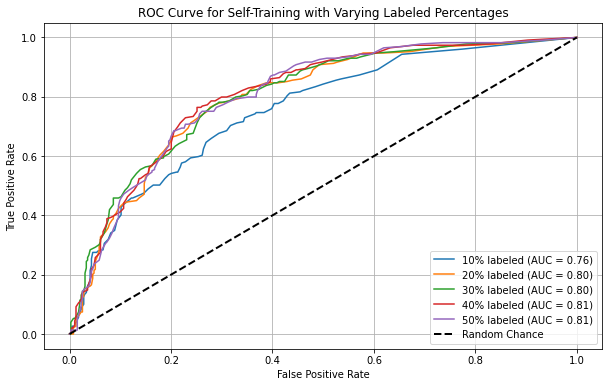

In [13]:
plot_roc_self_training(X_train, y_train, X_test, y_test, labeled_percentages)

#### CO-TRAINING

/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_17412/3661736189.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf2.fit(X_labeled_2, y_labeled)


Classification report with 10% of labelled data
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       394
           1       0.52      0.42      0.47       229

    accuracy                           0.64       623
   macro avg       0.61      0.60      0.60       623
weighted avg       0.63      0.64      0.63       623



/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_17412/3661736189.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf2.fit(X_labeled_2, y_labeled)


Classification report with 20% of labelled data
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       394
           1       0.52      0.33      0.40       229

    accuracy                           0.64       623
   macro avg       0.60      0.58      0.57       623
weighted avg       0.62      0.64      0.62       623



/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_17412/3661736189.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf2.fit(X_labeled_2, y_labeled)


Classification report with 30% of labelled data
              precision    recall  f1-score   support

           0       0.70      0.77      0.74       394
           1       0.53      0.44      0.48       229

    accuracy                           0.65       623
   macro avg       0.62      0.61      0.61       623
weighted avg       0.64      0.65      0.64       623



/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_17412/3661736189.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf2.fit(X_labeled_2, y_labeled)


Classification report with 40% of labelled data
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       394
           1       0.57      0.52      0.55       229

    accuracy                           0.68       623
   macro avg       0.65      0.65      0.65       623
weighted avg       0.68      0.68      0.68       623



/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/bs/nn1_9vm534jds0wld0rskgf40000gn/T/ipykernel_17412/3661736189.py:40: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf2.fit(X_labeled_2, y_labeled)


Classification report with 50% of labelled data
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       394
           1       0.55      0.41      0.47       229

    accuracy                           0.66       623
   macro avg       0.63      0.61      0.61       623
weighted avg       0.65      0.66      0.65       623



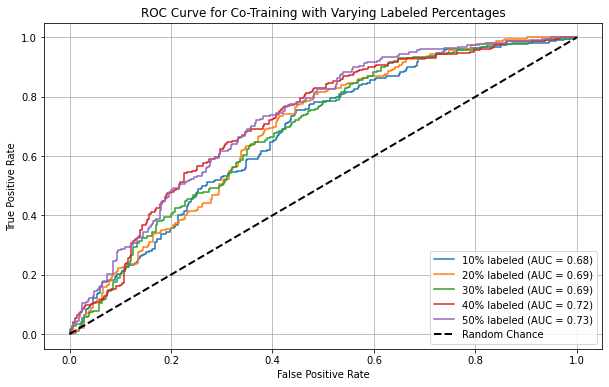

In [14]:
plot_roc_co_training(X_train, y_train, X_test, y_test, labeled_percentages)

#### SEMI-BOOST

Classification report with 10% of labelled data
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       394
           1       0.00      0.00      0.00       229

    accuracy                           0.63       623
   macro avg       0.32      0.50      0.39       623
weighted avg       0.40      0.63      0.49       623

Classification report with 20% of labelled data
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       394
           1       0.00      0.00      0.00       229

    accuracy                           0.63       623
   macro avg       0.32      0.50      0.39       623
weighted avg       0.40      0.63      0.49       623

Classification report with 30% of labelled data
              precision    recall  f1-score   support

           0       0.63      1.00      0.77       394
           1       0.00      0.00      0.00       229

    accuracy                          

/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bhavneetsingh/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

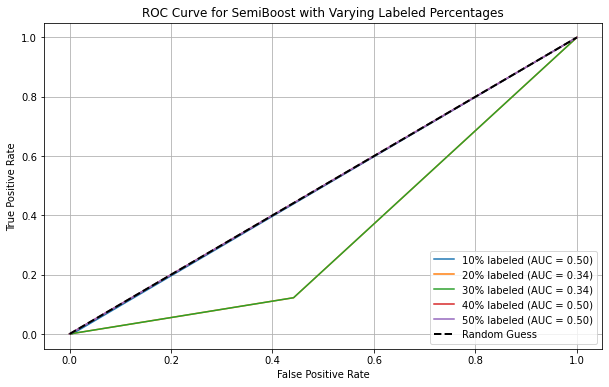

In [15]:
semi_boost(X_train, y_train, X_test, y_test, labeled_percentages)

#### PCA

Classification report with 10% of labelled data
              precision    recall  f1-score   support

           0       0.67      0.90      0.77       394
           1       0.59      0.26      0.36       229

    accuracy                           0.66       623
   macro avg       0.63      0.58      0.56       623
weighted avg       0.64      0.66      0.62       623

Classification report with 20% of labelled data
              precision    recall  f1-score   support

           0       0.69      0.88      0.77       394
           1       0.60      0.31      0.40       229

    accuracy                           0.67       623
   macro avg       0.64      0.59      0.59       623
weighted avg       0.65      0.67      0.64       623

Classification report with 30% of labelled data
              precision    recall  f1-score   support

           0       0.72      0.80      0.76       394
           1       0.58      0.46      0.51       229

    accuracy                          

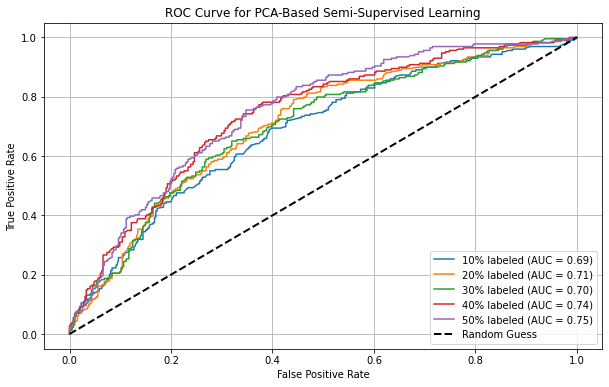

In [16]:
semi_supervised_components(X_train, y_train, X_test, y_test, labeled_percentages)

In [17]:
print(gradient_boost,
self_training,
co_training,
semi_boost_accuracy,
pca_semi_supervised)

[0.6452648475120385, 0.6597110754414125, 0.6934189406099518, 0.6853932584269663, 0.680577849117175] [0.709470304975923, 0.7271268057784912, 0.7383627608346709, 0.7383627608346709, 0.7463884430176565] [0.6420545746388443, 0.6420545746388443, 0.6500802568218299, 0.680577849117175, 0.6597110754414125] [0.6324237560192616, 0.6324237560192616, 0.6324237560192616, 0.6324237560192616, 0.6324237560192616] [0.6613162118780096, 0.6693418940609952, 0.6789727126805778, 0.6918138041733547, 0.6869983948635634]


In [20]:
accuracies = pd.DataFrame({
    "Percentage of Labeled Data": labeled_percentages,
    "GradientBoost": gradient_boost,
    "Self-Training" : self_training,
    "Co-Training": co_training,
    "Semi_Boost": semi_boost_accuracy,
    "PCA": pca_semi_supervised
})

In [21]:
accuracies

,Percentage of Labeled Data,GradientBoost,Self-Training,Co-Training,Semi_Boost,PCA
0,10,0.645265,0.709470,0.642055,0.632424,0.661316
1,20,0.659711,0.727127,0.642055,0.632424,0.669342
2,30,0.693419,0.738363,0.650080,0.632424,0.678973
3,40,0.685393,0.738363,0.680578,0.632424,0.691814
4,50,0.680578,0.746388,0.659711,0.632424,0.686998
